In [419]:
import os
import pandas as pd
from fastbook import *
from fastai.tabular.all import *
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from dtreeviz.trees import *
import sklearn

def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

traindf = pd.read_csv('/mnt/c/Users/jsult/Desktop/spacetitanic3/train.csv',low_memory=False)
testdf = pd.read_csv('/mnt/c/Users/jsult/Desktop/spacetitanic3/test.csv',low_memory= False)
traindf.dropna(inplace = True)

nas = list(testdf.isna().sum(axis = 1))
indexes = list(testdf.index)
keepinds = []
dropinds = []
for i in range(len(indexes)):
    if nas[i] == 0:
        keepinds.append(i)
    else:
        dropinds.append(i)
droptest = testdf.loc[dropinds].copy()
testdf = testdf.loc[keepinds].copy()




split columns

In [420]:
def split_cabin(df):
    df['CabinDeck'] = df['Cabin'].apply(lambda x: x.split("/" )[0] if pd.notna(x) else pd.NA)
    df['CabinSide'] = df['Cabin'].apply(lambda x: x.split("/")[2] if pd.notna(x) else pd.NA)
    df['CabinNum'] = df['Cabin'].apply(lambda x: int(x.split("/")[1]) if pd.notna(x) else pd.NA)
    return df

traindf = split_cabin(traindf)
testdf= split_cabin(testdf)

In [421]:
def split_names(df):
    # Create new columns for first name and last name
    df['FirstName'] = df['Name'].apply(lambda x: x.split()[0] if pd.notna(x) else pd.NA)
    df['LastName'] = df['Name'].apply(lambda x: x.split()[1] if pd.notna(x) else pd.NA)
    return df


traindf = split_names(traindf)
testdf = split_names(testdf)

In [422]:
def split_group_number(df):
    df['Group'] = df['PassengerId'].apply(lambda x: x.split("_")[0] if pd.notna(x) else pd.NA)
    df['GroupNumber'] = df['PassengerId'].apply(lambda x: x.split("_")[1] if pd.notna(x) else pd.NA)
    return df


traindf = split_group_number(traindf)
testdf = split_group_number(testdf)

Age

In [423]:
traindf.isna().sum()

PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
Transported     0
CabinDeck       0
CabinSide       0
CabinNum        0
FirstName       0
LastName        0
Group           0
GroupNumber     0
dtype: int64

In [424]:

def categorize_age(train_df, test_df):
    """
    Categorize 'Age' column into 4 bins and apply the same categorization to both training and testing DataFrames.

    Parameters:
    train_df (pd.DataFrame): Training DataFrame.
    test_df (pd.DataFrame): Testing DataFrame.

    Returns:
    pd.DataFrame: Updated training and testing DataFrames with the 'AgeCategory' column.
    """
    # Define bin edges based on training data
    bins = [-1, 19, 27, 38, 100]  # Modify bin edges as needed

    # Categorize 'Age' into bins for both training and testing data
    train_df['AgeCategory'] = pd.cut(train_df['Age'], bins, labels=['<20', '20-40', '40-60', '60+'])
    test_df['AgeCategory'] = pd.cut(test_df['Age'], bins, labels=['<20', '20-40', '40-60', '60+'])

    return train_df, test_df

# Assuming train_df and test_df are your training and testing DataFrames
traindf, testdf = categorize_age(traindf, testdf)


In [425]:
traindf[traindf.AgeCategory.isna()]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,CabinDeck,CabinSide,CabinNum,FirstName,LastName,Group,GroupNumber,AgeCategory


Cabin

In [426]:
def cabin_size(row):
    samecabin = traindf[traindf.Cabin == row.Cabin]
    return len(samecabin)

traindf['CabinSize'] = traindf.apply(cabin_size, axis = 1)
testdf['CabinSize'] = testdf.apply(cabin_size,axis = 1)

Family Member

In [427]:
def family_size(df):
    df['FamilySize'] = df.apply(lambda row: len(df[(df['LastName'] == row['LastName']) & (df['Group'] == row['Group'])]), axis=1)
    return df

traindf = family_size(traindf)
testdf = family_size(testdf)


Group

In [428]:
def group_size(row):
    group = traindf[traindf.Group == row.Group]
    return len(group)


traindf['GroupSize'] = traindf.apply(group_size, axis = 1)
testdf['GroupSize'] = testdf.apply(group_size,axis = 1)

Spending

In [429]:
def total_spending_without_roomservice(df):
    df['TotalSpendingwo'] = df['FoodCourt'] + df['ShoppingMall'] + df['Spa'] + df['VRDeck']
    return df
traindf = total_spending_without_roomservice(traindf)
testdf = total_spending_without_roomservice(testdf)

In [430]:
def total_spending(df):
    df['TotalSpending'] = df['FoodCourt'] + df['ShoppingMall'] + df['Spa'] + df['VRDeck'] + df['RoomService']
    return df
traindf = total_spending(traindf)
testdf = total_spending(testdf)

In [431]:
def categorize_age_and_spending(df):
    df['ageandspending'] = df.apply(lambda row: 'young' if row['Age'] < 18 else ('rich' if row['TotalSpending'] > 750 else 'poor'), axis=1)
    return df
traindf = categorize_age_and_spending(traindf)
testdf = categorize_age_and_spending(testdf)

In [432]:
def categorize_individuals(df):
    """
    Categorize individuals based on age, cryosleep status, and total spending.

    Parameters:
    df (pd.DataFrame): Input DataFrame with 'Age', 'CryoSleep', and 'TotalSpending' columns.

    Returns:
    pd.DataFrame: DataFrame with an additional 'Category' column based on the given conditions.
    """
    # Categorize based on cryosleep status
    df['asleepymoney'] = df.apply(lambda row: 'asleep' if row['CryoSleep'] else (
        'young' if row['Age'] < 18 else ('rich' if row['TotalSpending'] > 750 else 'poor')), axis=1)
    return df
traindf = categorize_individuals(traindf)
testdf = categorize_individuals(testdf)


In [433]:
todrop = ['Group','Cabin','Name','GroupSize','TotalSpendingwo','FirstName']

model

In [434]:
traindf = traindf.drop(columns = todrop)
testdf = testdf.drop(columns = todrop)

/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastai/data/transforms.py:225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/jakeunix/miniforge3/envs/sptitanic/lib/pyth

decision tree prediction 0.8046934140802422


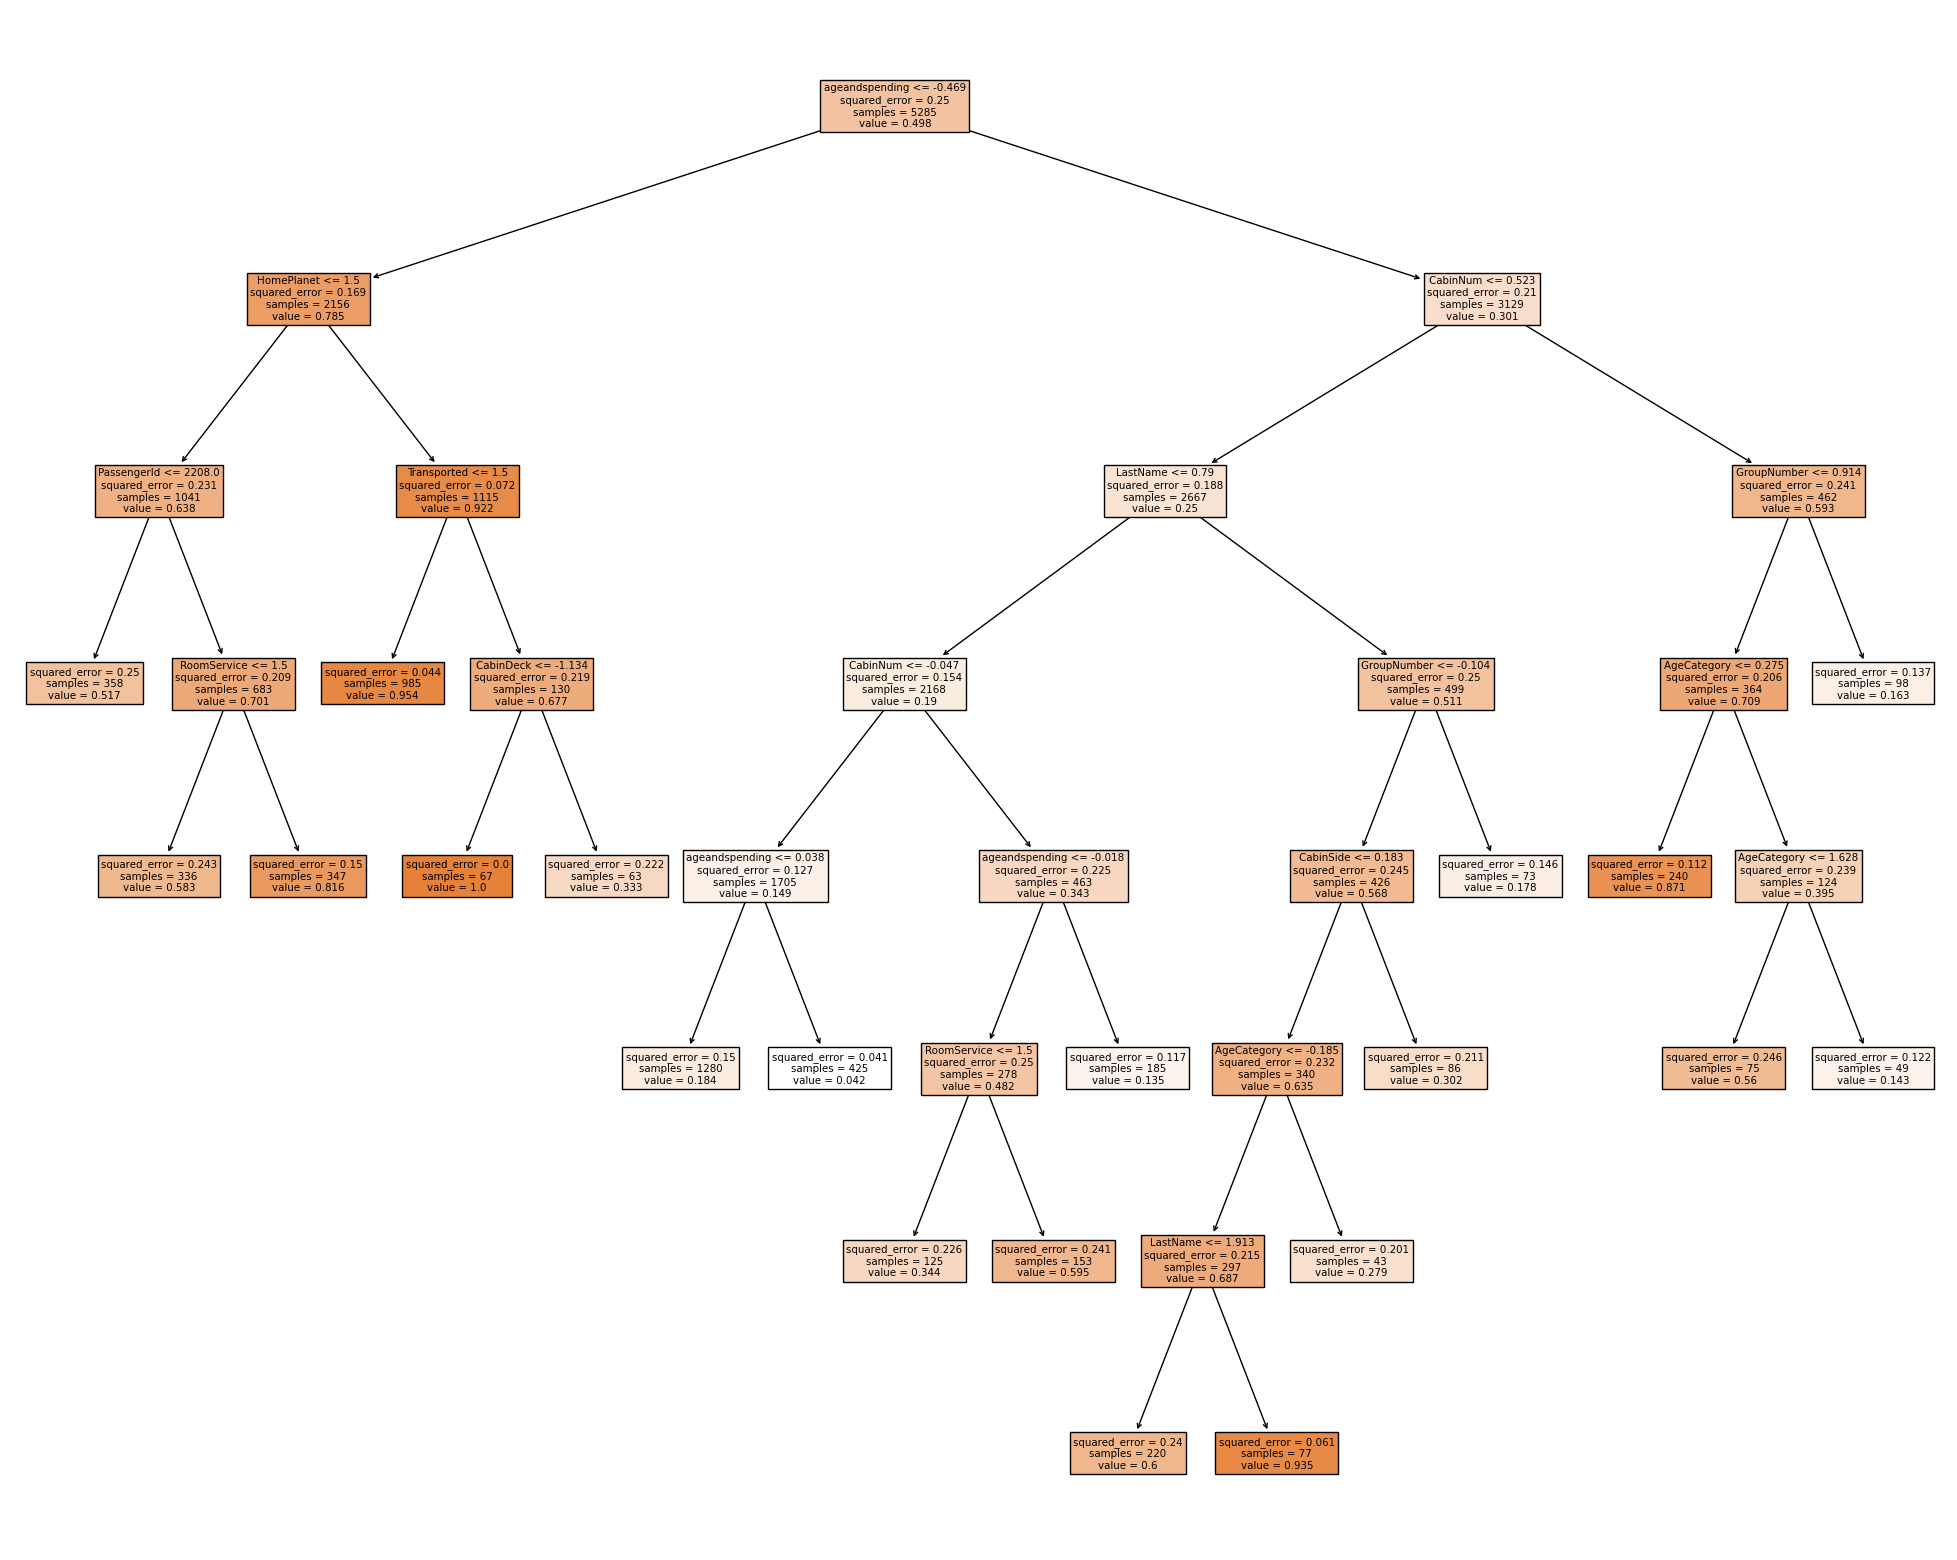

In [435]:
splits = RandomSplitter(seed = 1)(range_of(traindf))
dep_var = 'Transported'
procs = [Categorify,FillMissing,Normalize]
cont,cat = cont_cat_split(traindf, 1, dep_var=dep_var)
to = TabularPandas(traindf, procs, cat, cont, y_names=dep_var,splits = splits)

xs,y = to.train.xs,to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

m = DecisionTreeRegressor(max_leaf_nodes=20)
m.fit(xs, y)

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(m,
                   feature_names= traindf.columns,
                   filled=True)

print('decision tree prediction',((m.predict(valid_xs) > 0.5) == valid_y).sum() / len(valid_y))

In [436]:
m = RandomForestClassifier(n_estimators= 100, max_leaf_nodes= 50)
m.fit(xs, y)
preds = m.predict(valid_xs)
print("mae",mean_absolute_error(valid_y, preds))
print('preds', (preds == valid_y).sum() /len(valid_y))


mae 0.20136260408781226
preds 0.7986373959121877


In [437]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

fi = rf_feat_importance(m, xs)
print(fi[:30])

              cols       imp
11    asleepymoney  0.145132
21   TotalSpending  0.134850
16             Spa  0.098226
2        CryoSleep  0.093458
13     RoomService  0.087535
17          VRDeck  0.075859
14       FoodCourt  0.074587
15    ShoppingMall  0.060563
1       HomePlanet  0.043610
5        CabinDeck  0.038795
12             Age  0.026084
18        CabinNum  0.025468
10  ageandspending  0.022850
0      PassengerId  0.021652
6        CabinSide  0.013048
7         LastName  0.012555
3      Destination  0.007755
19       CabinSize  0.006378
9      AgeCategory  0.004882
20      FamilySize  0.003760
8      GroupNumber  0.002531
4              VIP  0.000423


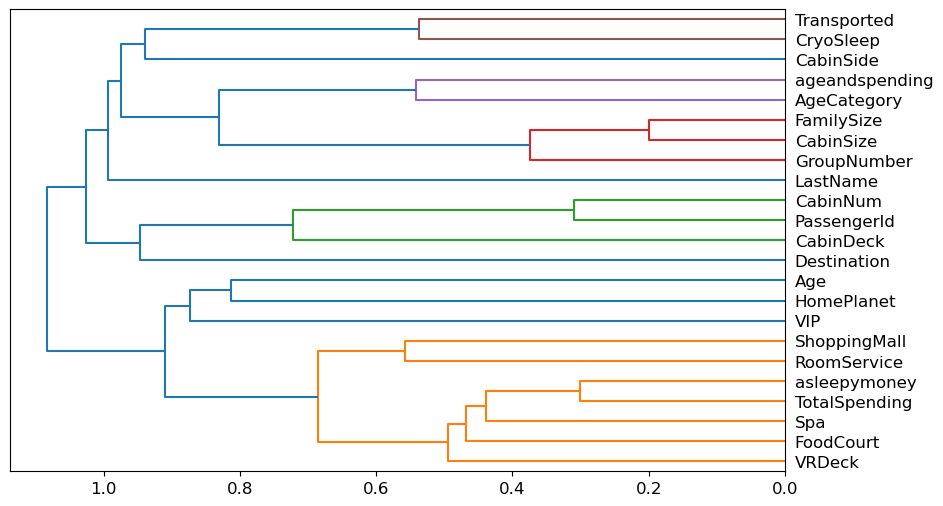

In [438]:
cluster_columns(traindf)


In [443]:
m = RandomForestRegressor(n_estimators=100, max_leaf_nodes = 50)
m.fit(xs,y)

RandomForestRegressor(max_leaf_nodes=50)

In [440]:
cont,cat = cont_cat_split(testdf, 1, dep_var=dep_var)
mode_values = testdf[cat].mode().iloc[0]
testdf[cat] = testdf[cat].fillna(mode_values)


for column in cont:
    mode_value = testdf[column].median()  # Calculate the mode for the column
    testdf[column].fillna(mode_value, inplace=True)  # Fill missing values with mode
    
to_new = to.train.new(testdf)
to_new.process()

lisss = list(m.predict(to_new.xs))


/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/jakeunix/miniforge3/envs/sptitanic/lib/python3

In [444]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15,max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_
get_oob(xs)


0.46463294154304724

In [446]:
traindf.asleepymoney

0         poor
1         poor
2         rich
3         rich
4        young
         ...  
8688      rich
8689    asleep
8690      rich
8691      rich
8692      rich
Name: asleepymoney, Length: 6606, dtype: object

In [445]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

fi = rf_feat_importance(m, xs)
print(fi[:30])

              cols       imp
21   TotalSpending  0.424037
14       FoodCourt  0.108576
15    ShoppingMall  0.083103
16             Spa  0.059255
1       HomePlanet  0.058997
17          VRDeck  0.053585
0      PassengerId  0.030949
12             Age  0.028337
11    asleepymoney  0.027012
18        CabinNum  0.026538
13     RoomService  0.019648
6        CabinSide  0.019009
2        CryoSleep  0.014248
7         LastName  0.014213
5        CabinDeck  0.012126
19       CabinSize  0.011599
3      Destination  0.004489
20      FamilySize  0.001901
8      GroupNumber  0.001353
9      AgeCategory  0.000590
4              VIP  0.000288
10  ageandspending  0.000146


In [417]:
traindf.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Transported', 'CabinDeck', 'CabinSide', 'CabinNum', 'LastName',
       'GroupNumber', 'AgeCategory', 'CabinSize', 'FamilySize',
       'TotalSpending', 'ageandspending', 'asleepymoney'],
      dtype='object')

In [418]:
{c:get_oob(xs.drop(c, axis=1)) for c in ['PassengerId', 'HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'CabinDeck', 'CabinSide', 'CabinNum', 'LastName',
       'GroupNumber', 'AgeCategory', 'CabinSize', 'FamilySize',
       'TotalSpending', 'ageandspending', 'asleepymoney']}

{'PassengerId': 0.46947983555330264,
 'HomePlanet': 0.4600937949020777,
 'CryoSleep': 0.46596304533240407,
 'Destination': 0.46049686041559157,
 'Age': 0.46630448548258274,
 'VIP': 0.4740535786566993,
 'RoomService': 0.46732548971340393,
 'FoodCourt': 0.4558912567833089,
 'ShoppingMall': 0.46525749793186855,
 'Spa': 0.4506665866732511,
 'VRDeck': 0.4506469988553967,
 'CabinDeck': 0.4606681987476491,
 'CabinSide': 0.45567505518247986,
 'CabinNum': 0.4641202923779886,
 'LastName': 0.4681146558109325,
 'GroupNumber': 0.46896877245729507,
 'AgeCategory': 0.4687471401121337,
 'CabinSize': 0.46994257133352135,
 'FamilySize': 0.465529280669165,
 'TotalSpending': 0.46317198740993015,
 'ageandspending': 0.46867559209576737,
 'asleepymoney': 0.46197200804543215}

In [383]:
todrop = ['Group','Cabin','Name','GroupSize','TotalSpendingwo','FirstName']

In [384]:
get_oob(xs.drop(todrop, axis=1))


0.46608054880291516

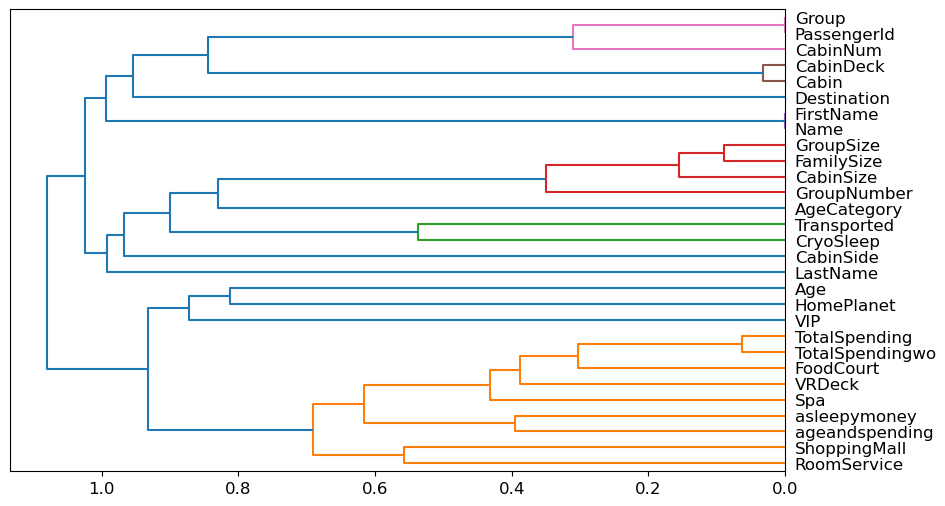

In [348]:
cluster_columns(traindf)


In [411]:
cont,cat = cont_cat_split(testdf, 1, dep_var=dep_var)
mode_values = testdf[cat].mode().iloc[0]
testdf[cat] = testdf[cat].fillna(mode_values)


for column in cont:
    mode_value = testdf[column].median()  # Calculate the mode for the column
    testdf[column].fillna(mode_value, inplace=True)  # Fill missing values with mode
    
to_new = to.train.new(testdf)
to_new.process()



testtran = [True if x == 1 else False for x in list(m.predict(to_new.xs))]
testdf['Transported'] = testtran



/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/jakeunix/miniforge3/envs/sptitanic/lib/python3

In [412]:
droptest['Transported'] = False
droptest = droptest[['PassengerId','Transported']]
testdf = testdf[['PassengerId','Transported']]

result = pd.concat([droptest,testdf])
result = result.sort_index()

result.to_csv('submit.csv',index=False)

all columns 0.72667 over 0.72574 base